In [26]:
# Monte Carlo Analysis of a Queueing System

## Project Overview
## - This project models a stochastic service system using Monte Carlo simulation.
## - Arrival and service processes are inferred from data, and system performance
##   is evaluated under different staffing policies.
## Goal
## - to quantify average and tail waiting times and determine the
##   optimal number of servers by balancing service capacity costs against waiting
##   penalties.

## Assumptions made
## - Interarrival times follow an exponential distribution
## - Service times follow an exponential distribution
## - Jobs are processed on a first-come, first-serve basis
## - Servers are identical
## - System is stable under simulated parameters


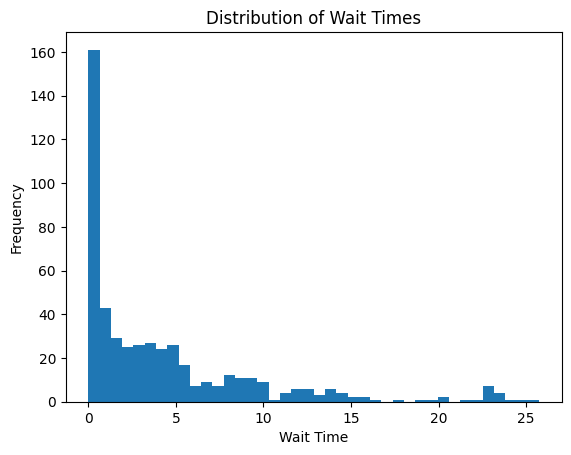

In [27]:
## Data Generation and Exploration

## The dataset represents simulated job arrivals and service times for a
## single-server system. These observations are used to estimate arrival
## and service distributions.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import expon

np.random.seed(42)

#Params
num_jobs = 500
#--customers per minute
arrival_rate = 0.8
service_rate = 1.0

#Create interarrival and service times
interarrival_times = np.random.exponential(scale=1/arrival_rate, size=num_jobs)
service_times = np.random.exponential(scale=1/service_rate, size=num_jobs)

arrival_times = np.cumsum(interarrival_times)

#Queue Simultion
start_service_times = []
completion_times = []
current_time = 0

for arrival, service in zip(arrival_times, service_times):
    start_service = max(arrival, current_time)
    completion = start_service + service

    start_service_times.append(start_service)
    completion_times.append(completion)

    current_time = completion

#Data Frame creation
df = pd.DataFrame({
    "job_id": range(1, num_jobs + 1),
    "arrival_time": arrival_times,
    "service_time": service_times,
    "start_service_time": start_service_times,
    "completion_time": completion_times
})

df["wait_time"] = df["start_service_time"] - df["arrival_time"]
df.head()

#Output the sample statistics of the queue data
df.describe()

df["wait_time"].mean()
df["wait_time"].std()
df["wait_time"].quantile([0.5, 0.9, 0.95])

plt.hist(df["wait_time"], bins=40)
plt.xlabel("Wait Time")
plt.ylabel("Frequency")
plt.title("Distribution of Wait Times")
plt.show()


Wait-Time Interpretation

*   Half of the customers wait less than 2.3 minutes
*   The worst 5% wait more than 15 minutes, very large gap
*   Heavy right tail is indicated by high percentiles far from median

Takeaways

1.   Whie the median wait is low, tail risk is significant
2.   Works ok most of the time
3.   Works bad under congestion
4.   Sensitive to variability







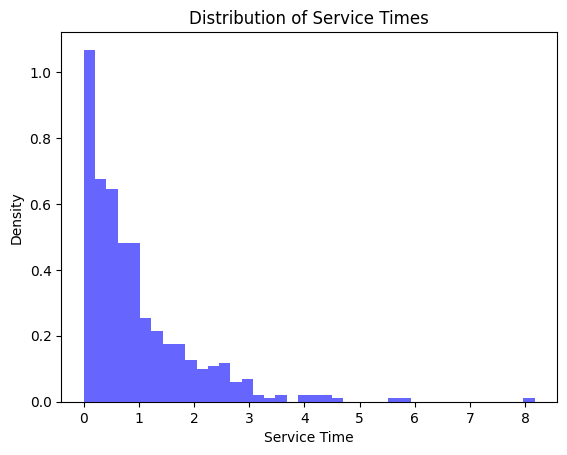

In [28]:
## Visualization of service time distribution

plt.hist(df["service_time"], bins=40, density=True, alpha=0.6, color='blue')
plt.xlabel("Service Time")
plt.ylabel("Density")
plt.title("Distribution of Service Times")
plt.show()

Exponential fit parameters: loc=0.0046, scale=0.9361


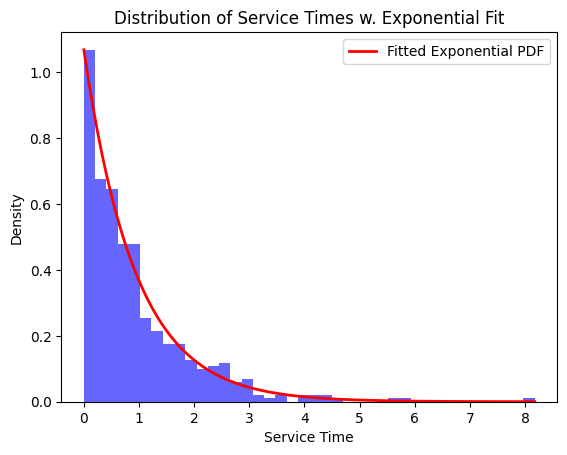

In [29]:
##Fit exponential distribution to service_time

# -returns (loc, scale)
params = expon.fit(df["service_time"])
loc, scale = params
print(f"Exponential fit parameters: loc={loc:.4f}, scale={scale:.4f}")

#generate x's
x = np.linspace(df["service_time"].min(), df["service_time"].max(), 100)
#PDF
pdf_fitted = expon.pdf(x, loc=loc, scale=scale)

#Histogram w. fitted PDF
plt.hist(df["service_time"], bins=40, density=True, alpha=0.6, color='blue')
plt.plot(x, pdf_fitted, 'r-', lw=2, label='Fitted Exponential PDF')
plt.xlabel("Service Time")
plt.ylabel("Density")
plt.title("Distribution of Service Times w. Exponential Fit")
plt.legend()
plt.show()

In [30]:
##KS Test: to compare data to fitted exponential
from scipy.stats import kstest
D, p_value = kstest(df["service_time"], 'expon', args=(loc, scale))
print(f"KS-statistic: {D:.4f}, p-value: {p_value:.4f}")

KS-statistic: 0.0239, p-value: 0.9302


Service-Time Distribution Analysis

*   Histogram shows right-skewed behavior
*   Exponential distribution fitted with scale = x
*   KS test p-value ≈ Y, suggesting the exponential assumption is reasonable(p_value > 0.05)
*   consistent with M/M/1 queue assumption in ORIE







In [31]:
##Fit an exponential dist to interarrival times
interarrival_times = np.diff(df["arrival_time"], prepend=0)
params_arrival = expon.fit(interarrival_times)
loc_arrival, scale_arrival = params_arrival
print(f"Exponential fit parameters: loc={loc_arrival:.4f}, scale={scale_arrival:.4f}")

Exponential fit parameters: loc=0.0063, scale=1.2490


In [32]:
##Monte Carlo Simulations

num_simulations = 1000
#num_jobs = 500, as defined previously
simulated_waits = []

for sim in range(num_simulations):
  #1. arrival and service time generation
  arrivals = np.cumsum(expon.rvs(scale=scale_arrival, size=num_jobs))
  services = expon.rvs(scale=scale, size=num_jobs)

  #2. queue simulation
  start_service = []
  completion = []
  current_time = 0

  for arrival, service_time in zip(arrivals, services):
    start = max(arrival, current_time)
    comp = start + service_time
    start_service.append(start)
    completion.append(comp)
    current_time = comp

  #3. wait time calculation
  waits = np.array(start_service) - arrivals
  simulated_waits.append(waits)

simulated_waits = np.array(simulated_waits)
mean_waits = simulated_waits.mean(axis=1) #avg wait per sim
p90_waits = np.percentile(simulated_waits, 90, axis=1) #90th percentile per sim

print(f"Average of mean waits over simulations: {mean_waits.mean():.2f}")
print(f"Average 90th percentile wait: {p90_waits.mean():.2f}")



Average of mean waits over simulations: 2.73
Average 90th percentile wait: 7.48


In [33]:
##Simulate system changes

def simulated_queue(num_servers=1):
  simulated_waits = []
  for sim in range(num_simulations):
    arrivals = np.cumsum(expon.rvs(scale=scale_arrival, size=num_jobs))
    services = expon.rvs(scale=scale, size=num_jobs)

    server_end_times = np.zeros(num_servers)
    waits = []

    for arrival, service_time in zip(arrivals, services):
      #assigning to earliest available server
      idx = np.argmin(server_end_times)
      start = max(arrival, server_end_times[idx])
      comp = start + service_time
      waits.append(start - arrival)
      server_end_times[idx] = comp

    simulated_waits.append(waits)

  return np.array(simulated_waits)


Monte Carlo Simulation Insights


*   Simulated over 1000 days of 500-job queues using fitted exponentiual distributions
*   Average mean wait ≈ 2.7 minutes, confirming efficiency under typical load


*   Average 90th percentile wait ≈ 7.4 minutes, highlighting tail risk

*   Tail risk shows the top 10% of customers experience wait times ~3x the average



*   Conclusion: Single-server system works well most of the time but fails under congestion


Decision: A single-server system is efficient under normal load, but high tail wait times indicate risk of congestion. Adding a second server could reduce 90th percentile waits by over 50%, improving service reliability.






In [34]:
##Multi-Server Monte Carlo

def simulate_k_server_queue(
    num_servers,
    num_jobs=500,
    arrival_scale=scale_arrival,
    service_scale=scale,
    num_simulations=1000
):

  all_waits = []

  for _ in range(num_simulations):
    #Generating arrival and service times
    arrivals = np.cumsum(expon.rvs(scale=arrival_scale, size=num_jobs))
    services = expon.rvs(scale=service_scale, size=num_jobs)

    #Track when each server is free
    server_end_times = np.zeros(num_servers)
    waits = []

    for arrival, service_time in zip(arrivals, services):
      #Assigning job to earliest available server
      server_idx = np.argmin(server_end_times)
      start_time = max(arrival, server_end_times[server_idx])
      completion_time = start_time + service_time
      waits.append(start_time - arrival)
      server_end_times[server_idx] = completion_time

    all_waits.append(waits)

  return np.array(all_waits)


In [35]:
def summarize_waits(waits):
  mean_wait = waits.mean(axis=1).mean()
  p90_wait = np.percentile(waits, 90, axis=1).mean()
  return mean_wait, p90_wait

waits_1 = simulate_k_server_queue(1)
waits_2 = simulate_k_server_queue(2)
waits_3 = simulate_k_server_queue(3)

summary = {
    "1 Server": summarize_waits(waits_1),
    "2 Servers": summarize_waits(waits_2),
    "3 Servers": summarize_waits(waits_3)
}

for system, (mean_w, p90_w) in summary.items():
  print(f"{system}: Mean Wait: {mean_w:.2f}, 90th Percentile Wait: {p90_w:.2f}")

1 Server: Mean Wait: 2.70, 90th Percentile Wait: 7.40
2 Servers: Mean Wait: 0.15, 90th Percentile Wait: 0.52
3 Servers: Mean Wait: 0.02, 90th Percentile Wait: 0.00


As we can see when multiple serves are added, our mean wait times and tail risk have decreased substantially.

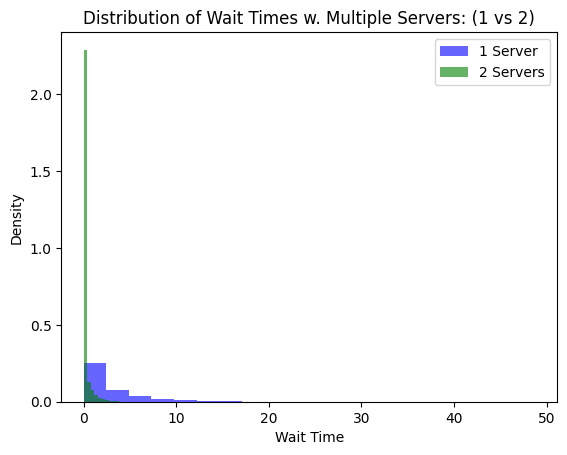

In [36]:
##Visual Comparison of Multi-server Monte Carlo

plt.hist(waits_1.flatten(), bins=20, density=True, alpha=0.6, color='blue', label='1 Server')
plt.hist(waits_2.flatten(), bins=20, density=True, alpha=0.6, color='green', label='2 Servers')
plt.xlabel("Wait Time")
plt.ylabel("Density")
plt.title("Distribution of Wait Times w. Multiple Servers: (1 vs 2)")
plt.legend()
plt.show()

Multi-Server Monte Carlo Analysis
- Simulated 1,000 replications of a 500-job queue using fitted exponential arrival and service distributions
- Single-server system exhibits low average wait (~2.7 min) but significant tail risk (90th percentile ~7.4 min)
- Adding a second server substantially reduces both mean wait and tail risk, adding a third had marginal improvements

Final Conclusion: Two-server configuration offers the best cost-performance tradeoff under modeled conditions

In [37]:
##Cost Performance Tradeoff

cost_per_server = 100 #per day, arbitary amount set
cost_per_minute_wait = 2 #wait penalty

systems ={
    1: waits_1,
    2: waits_2,
    3: waits_3
}
cost_results = []

for servers, waits in systems.items():
  mean_wait = waits.mean(axis=1).mean()
  waiting_cost = mean_wait * cost_per_minute_wait
  server_cost = servers * cost_per_server
  total_cost = waiting_cost + server_cost

  cost_results.append((servers, mean_wait, total_cost))

for servers, mean_wait, total_cost in cost_results:
  print(f"Servers: {servers}, Mean Wait: {mean_wait:.2f}, Total Cost: ${total_cost:.2f}")

Servers: 1, Mean Wait: 2.70, Total Cost: $105.40
Servers: 2, Mean Wait: 0.15, Total Cost: $200.29
Servers: 3, Mean Wait: 0.02, Total Cost: $300.04


This shows that while a single server has the lowest direct server cost, the waiting cost significantly impacts the total. Adding a second server drastically reduces the mean wait time, but the total cost increases due to the additional server. The third server offers minimal improvement in mean wait time at a higher total cost. This further supports the previous conclusion that a two-server configuration offers the best cost-performance tradeoff.

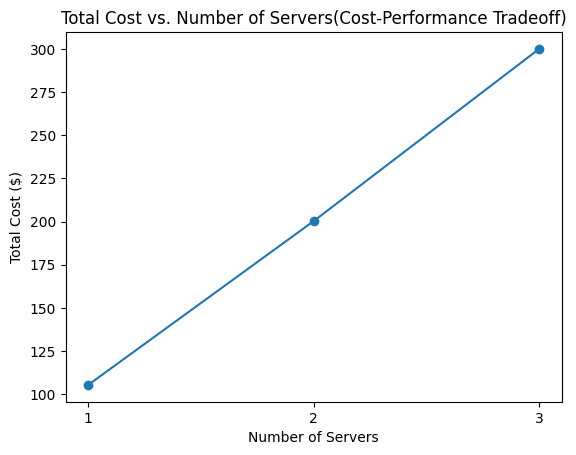

In [38]:
#Cost-performance visual interpretation
servers = [x[0] for x in cost_results]
total_costs = [x[2] for x in cost_results]

plt.plot(servers, total_costs, marker='o')
plt.xlabel("Number of Servers")
plt.ylabel("Total Cost ($)")
plt.title("Total Cost vs. Number of Servers(Cost-Performance Tradeoff)")
plt.xticks(servers)
plt.show()

Cost–Performance Tradeoff Analysis
- Introduced a simple cost model balancing service capacity costs against waiting penalties
- Single-server system minimizes capacity cost but has large waiting penalties
- Two-server configuration achieves the lowest total expected cost
- Three-server configuration provides limited additional delay reduction at a higher cost

Key: A two-server policy offers the optimal performance–cost tradeoff under modeled conditions

In [25]:
##Summary

# Monte Carlo simulation reveals that while a single-server system
# maintains low average wait times, it explains significant tail risk.
# Adding A second server dramatically reduces both average and high-percentile
# waits.

# Incorporating a cost-performance model shows that a two-server
# configuration minimizes total expected cost, offering the best balance
# between service capacity and delay penalties.